Epoch 1/50
72/72 [==============================] - 85s 1s/step - loss: 0.7578 - accuracy: 0.6812 - val_loss: 0.7302 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 80s 1s/step - loss: 0.5516 - accuracy: 0.7795 - val_loss: 0.8757 - val_accuracy: 0.6798 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 81s 1s/step - loss: 0.4641 - accuracy: 0.8195 - val_loss: 0.8801 - val_accuracy: 0.6877 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 79s 1s/step - loss: 0.4608 - accuracy: 0.8226 - val_loss: 0.7852 - val_accuracy: 0.7115 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 79s 1s/step - loss: 0.3725 - accuracy: 0.8608 - val_loss: 0.6771 - val_accuracy: 0.7747 - lr: 2.0000e-04
Epoch 6/50
72/72 [==============================] - 80s 1s/step - loss: 0.3655 - accuracy: 0.8621 - val_loss: 0.6615 - val_accuracy: 0.7708 - lr: 2.0000e-04
Epoch 7/50
72/72 [==============================] - 79s 1s/step - loss: 0.

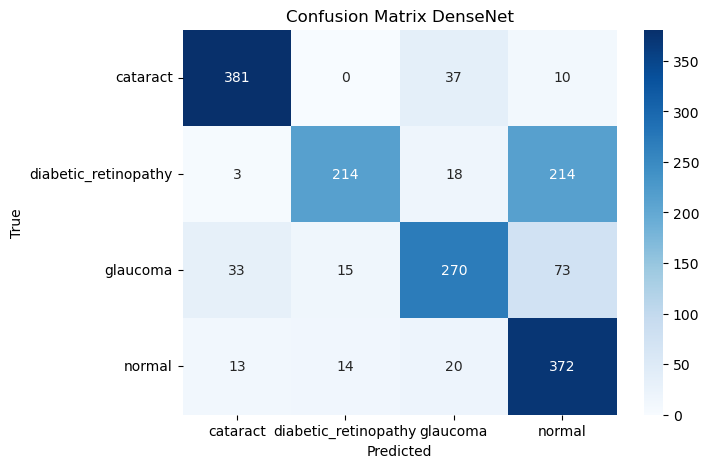

                      precision    recall  f1-score   support

            cataract       0.89      0.89      0.89       428
diabetic_retinopathy       0.88      0.48      0.62       449
            glaucoma       0.78      0.69      0.73       391
              normal       0.56      0.89      0.68       419

            accuracy                           0.73      1687
           macro avg       0.78      0.74      0.73      1687
        weighted avg       0.78      0.73      0.73      1687



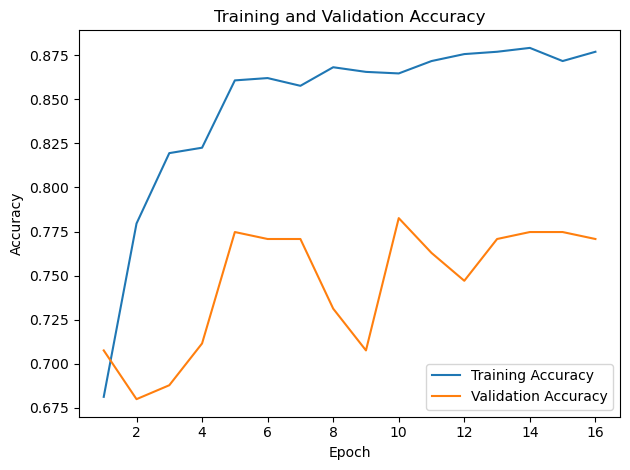

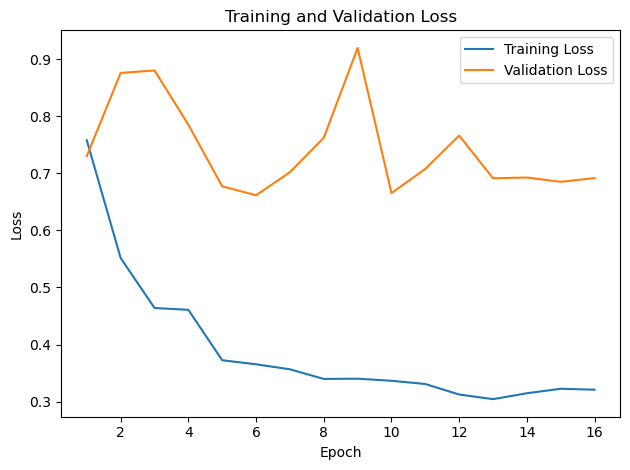

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set your data and category paths
Data = "C:/Users/USER/Terumbu_karang_CNN/Dataset2"
Categories = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

img_size = 224  # Adjust the image size based on DenseNet's input requirements

# Load and preprocess images
def load_and_preprocess_images(data_path, img_size):
    data = []
    labels = []
    for category in Categories:
        path = os.path.join(data_path, category)
        class_num = Categories.index(category)
        for img_name in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, img_name))
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(class_num)
            except Exception as e:
                pass
    data = np.array(data, dtype=np.float32) / 255.0
    labels = to_categorical(labels, num_classes=len(Categories))
    return data, labels

x, y = load_and_preprocess_images(Data, img_size)

# Split data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create your own classifier (top layers)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(len(Categories), activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with validation data
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Testing the model with testing data
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print("Accuracy on testing data:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(7, 5))  # Adjust the figure size here
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix DenseNet')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

# Plot accuracy and loss
# plt.figure(figsize=(12, 6))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.show()

# Plot loss
# plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show()